# Time averaged projection - supporting simulation code

---

This notebook demonstrates the basic concept of image projection enhancement as discussed in the supporting paper[1]. It generates the figures that are shown in Fig. 1.


[1]: Paper available [here](https://Putlinkhere)

This code simulates time-averaged image projection in the Fourier plane of an SLM. This setup is well-suited to project focal-point-like items. We optimize such that a particular intensity pattern. To make life difficult, we'll choose a target intensity distribution that is not well matched to the optical system, such as a slowly varying intensity pattern.


Normally, this would mean that the low-frequency components cannot be displayed as they would be attenuated by the beam stop. We will show that using our multi-pattern illumination we can circumvent this limitation.

Note that this notebook makes heavy use of features available in JAX, the documentation for which is available on 

https://jax.readthedocs.io/en/latest/


# Uncomment and run this cell if running from google colab. Otherwise, just continue

WARNING: You have to restart the notebook after executing the next cell

In [94]:
#install additional dependencies for google colab
# install a library to generate a QR code
#!pip install qrcode
#!pip install matplotlib==3.4
#!pip install -U git+https://github.com/nestordemeure/AdaHessianJax.git jax

# library to read a QR code
#!sudo apt-get install libzbar0
#!pip install pyzbar

In [3]:
# libraries we'll need
# visualisation
%matplotlib inline
from mpl_toolkits.axes_grid1.axes_rgb import RGBAxes
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm # progress bar
from mpl_toolkits import axes_grid1

# numerical processing
import numpy as np
# image processing operations
from skimage.metrics import structural_similarity as ssim
from skimage.transform import resize, downscale_local_mean
# I/O
import imageio


# Optimization library
import jax
from jax import random
from jax import numpy as jnp

from jax.experimental import optimizers


# QR image analysis
import qrcode
from pyzbar.pyzbar import decode
from PIL import Image

from IPython.display import clear_output
from matplotlib import ticker
import time

As a target, we will create a QR code that links to this document.

# Simulation settings

In our simulation, we presume that a lens can be approximated by a Fourier transform. Hence, provided that a suitable SLM can be manufactured, this should hold for any wavelength.

In [5]:
# definitions and sizes of the simulation
# simulation parameters
ndist = 512 # number of pixels in the image plane
nprox = 128 # number of pixels of the SLM

# random-number generator seed
seed = 1
key = random.PRNGKey(seed)

# Define the target intensity distribution

(648, 648)
(648, 648)
Could read QR code?: 1


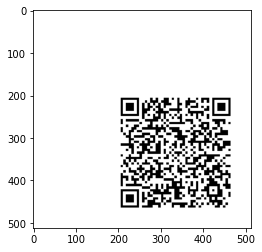

In [6]:
def make_target():
    # Make a target intensity distribution
    ss = slice(256-ndist, 256-ndist+2*ndist,2)
    target_image = imageio.imread('imageio:camera.png')[ss,ss]#[100:100+ndist*2:2,170:170+2*ndist:2]
    return target_image


URL = "https://colab.research.google.com/drive/16KPeBUnS2fBX9KAQLXq91m0Qr6ayMvpE?usp=sharing"
def make_QR(data=URL):
    """
    Make a QR code for a URL
    """
    qr = qrcode.QRCode(
#        version=1,
 #       error_correction=qrcode.constants.ERROR_CORRECT_H,
        box_size=8,
        border=20,
    )

    qr.add_data(data=data)
    img = np.array(qr.make_image())#fill_color='white', back_color='black'))
    img = np.roll(img, axis=0, shift=100)
    img = np.roll(img, axis=1, shift=100)
    print(img.shape)
    img = resize(img.astype(float), [ndist, ndist],anti_aliasing=False).astype(bool).astype(np.float32)
    return img

def analyze_QR(image, target_text):
    """ Test that the QR code can be read. 

    Returns:
        QR_OK: int
            1 if succesfully read, 0 if not 
    """
    img = image - image.min()
    img = img / img.max()
    #img = img > 0.5
    img = 255 * img.astype(np.float32)
    image_pil = Image.fromarray(jax.device_get(img).astype(np.uint8))
    result =  decode(image_pil)
    # print(result)
    
    if len(result) == 0:
        # Did not work
        return 0
    if result[0].data.decode() == target_text:
        # Decoded text matches
        return 1
    else:
        # something weird happened
        return result[0]
            

def normalize_target(tg):
    """ Normalize the target intensity distribution """
    return tg / tg.mean()

I_tg = normalize_target(make_QR())
plt.imshow(I_tg, cmap='gray')

print(f'Could read QR code?: {analyze_QR(make_QR(), URL):b}')



# Forward model specification

In [7]:
def FT(x, image_with_output_shape):
    """ Do a centralized fourier transform over the last two axes of a stack of images """
    return jnp.fft.fftshift(
        jnp.fft.fft2(
            jnp.fft.ifftshift(
                x, axes=(-2,-1),
            ), s=image_with_output_shape.shape,
        ), axes=(-2,-1)
    ) / x.shape[-1]**2


def phi_to_I_ff(phi, image_with_output_shape):
    """
    Compute the relation between the input phase on the SLM and the intensity
    intensity projected at the camera.

    This does not do the time-averaging operation yet 
    """
    npat_per_frame, nprox, _ = phi.shape
    esw_slm = jnp.exp(1j*phi).reshape(npat_per_frame, nprox, nprox) #/ nprox**2 * ndist**3
    Eout = FT(esw_slm, image_with_output_shape) * ndist * (nprox/ndist)
    return abs(Eout)**2 

@jax.jit
def forward_ff(phi, image_with_output_shape):#* ndist**2/nprox#/ndist*nprox
    """ Compute the time-averaged intensity given a set of input patterns phi """
    I_instantaneous = phi_to_I_ff(phi, image_with_output_shape)
    return I_instantaneous.sum(0).reshape(image_with_output_shape.shape)



In [8]:
def loss_mse(I_fw, I_tg):
    """ Calculate the mean squared difference loss.

    Note: In the experiments we employ the weighted structural similarity, but keep the code to manageable size, we employ the l2 difference in this simulation.
    """
    diff = I_fw - I_tg
    return jnp.sum(diff**2)

In [9]:
def costfunction(ph_in, I_tg):
    """ Calculate the value of the loss function for a given set of input patterns and a given target intensity image.

    Also returns the predicted intensity.
    
    Parameters:
        ph_in: jax array of size [npat_per_frame, nprox**2]
            The input phase patterns
        I_tg: jax array of size [ndist, ndist]
            Target intensity distribution
        T: transmission matrix of size [ndist**2, nprox**2]


    """
    I_fw = forward_ff(ph_in, I_tg)
    return loss_mse(I_fw, I_tg), I_fw

# Check what the maximum gradient step is in radians. 
jax.grad(costfunction, has_aux=True)(np.random.rand(1,nprox, nprox), I_tg)[0].max()

DeviceArray(248249.22, dtype=float32)

In [10]:
# see jax tutorials for information on how to use the optimizers
op_init, op_update, op_get = optimizers.adam(.2)


@jax.jit
def optimization_step(i, state, I_tg, scaling):
    """
    Perform a single step of the optimization. This function takes the current estimate of the phases (wrapped in state), the target intensity distribution (I_tg) and the transmission matrix T
    and returns a new state that (hopefully) improves the resulting image.

    Scaling can be used in case the gradient turns out to be too big (it should be in the range of 0-2 pi).

    """
    # get the current estimate of the SLM
    phase = op_get(state)
    # compute the value, the predicted intensity and the gradient of our data term
    (val, I_fw), grad = jax.value_and_grad(costfunction, has_aux=True)(phase, I_tg)
    # scale the gradient
    grad = grad * scaling
    # compute the typical update for every pixel (this is used to scale the gradient)
    avg_update = jnp.mean(grad*grad)
    # return the averaged update, predicted intensity and a new estimate of the patterns
    return avg_update, I_fw, op_update(i, grad, state)


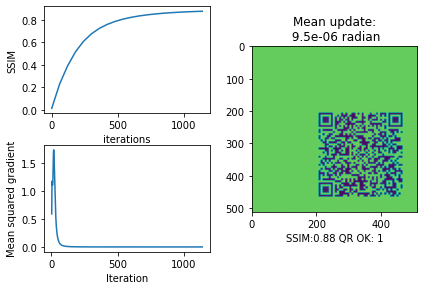

In [36]:
def optimize_time_averaged_projection(n_pat_per_frame=10, I_tg=I_tg,
                                      n_its = 1500, fig=None, ax=None):    
    # initialize the patterns
    p0 = np.random.rand(n_pat_per_frame, nprox, nprox)*2*np.pi*100
    
    # calculate the initial power coupled out
    P_out = forward_ff(p0, I_tg).sum()
    I_tg = np.array(jax.device_get(I_tg))
    I_tg_jax = jnp.asarray(I_tg.astype(np.float32))  * n_pat_per_frame

    state = op_init(jnp.array(p0))
    grad_step = np.zeros(n_its)
    scaling = 1
    ssims = []
    iterations_ssim = []
    show_every = n_its // 20
    for i in tqdm(range(n_its), desc='iterations'):
        grad_step[i], I_fw, state = optimization_step(i, state, I_tg_jax, scaling)
        if i < 10:
            # scale the gradient such that the mean averaged update is around 0.1 radian
            scaling =  scaling / np.sqrt(grad_step[i])
            
        if i % show_every == 0 and fig is not None:
            ssimscore = ssim(I_fw/I_fw.mean(), I_tg/I_tg.mean(), data_range=I_tg.max()/I_tg.mean())
            ssims.append(ssimscore)
            iterations_ssim.append(i)
            ax['grad'].cla()
            gradsteptoshow = grad_step.copy()
            # the first two steps are very big, as the gradient scaling is figured out. Do not show them
            gradsteptoshow[:2] = np.nan
            ax['grad'].plot(gradsteptoshow[:i])
            ax['grad'].set_ylabel('Mean squared gradient')
            ax['grad'].set_xlabel('Iteration')
            ax['image'].cla()
            ax['image'].imshow(I_fw)
            QR_OK = analyze_QR(I_fw, URL)
            ax['image'].set_xlabel(f'SSIM:{ssims[-1]:.2g} QR OK: {QR_OK}')
            
            ax['image'].set_title(f'Mean update:\n {grad_step[i-5:i].mean():.2g} radian')

            ax['cost'].cla()
            ax['cost'].plot(iterations_ssim, ssims)
            ax['cost'].set_xlabel('iterations')
            ax['cost'].set_ylabel('SSIM')
            
            display(fig)
#            print(I_fw.sum())
            clear_output(wait=True)
    return op_get(state), I_fw
fig, ax = plt.subplot_mosaic([['cost','image'],
                              ['grad','image']], constrained_layout=True)
fig.tight_layout()


optimize_time_averaged_projection(10, fig=fig, ax=ax, n_its=1200,
                                  );

# Show influence of number of patterns

Project the same scene using a varying number of patterns and show the influence on the projection fidelity

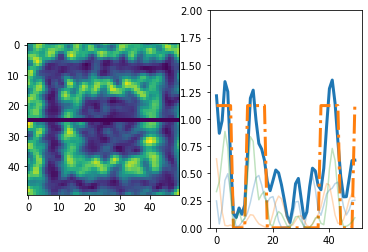

In [12]:

def make_time_image_plot(target, 
                         n_pat=5, sy= slice(200,250), sx = slice(200,250),
                         line_idx = 25, ss_line=slice(None, None)):
    """ Given a target intensity image distribution, compute three phase masks that correspond to 
    the right time-averaged intensity and show them side by side using different colors for different intensities.

    This figure is used in Fig. 1 of the paper.
    """
    p_opt, I_opt = optimize_time_averaged_projection(n_pat, n_its=50, I_tg=target)
    Iout_instantaneous = phi_to_I_ff(p_opt, target) / n_pat
    fig, ax = plt.subplots(1,2)
    I_opt_ss = I_opt[sy,sx]
    I_opt_ss =I_opt_ss.at[line_idx].set(0)
    line_intensity = Iout_instantaneous[:, sy, sx][:,ss_line, line_idx]
    li = Iout_instantaneous.reshape(n_pat, -1)
    li = li - li.mean(1, keepdims=True)
    li = li / np.std(li, axis=1, keepdims=True)
    #print('NCCR: \n', li@li.T/li.shape[1])
    tg_line = I_tg[sy, sx][ss_line, line_idx]
    
    ax[0].imshow(I_opt_ss)
    ax[1].plot(line_intensity.sum(0), color='C0', lw=3)
    ax[1].plot(tg_line, color='C1', lw=3, ls='-.')
    ax[1].set_prop_cycle(None)
    factor = 1
    if n_pat > 5:
        factor = 5
    ax[1].plot(factor*line_intensity.swapaxes(0,1), alpha=0.3)
    
    ax[1].set_ylim(0,2)
    return fig


fig = make_time_image_plot(I_tg, n_pat=3)
fig.savefig('Iout_123.svg', dpi=300)

In [13]:
#from mpl_toolkits.axes_grid1.axes_rgb import RGBAxes
def make_time_image(target, sy= slice(350, 500), sx = slice(350,500)):
    """ Given a target intensity image distribution, compute three phase masks that correspond to 
    the right time-averaged intensity and show them side by side using different colors for different intensities.

    This figure is used in Fig. 1 of the paper.
    """
    p_opt, I_opt = optimize_time_averaged_projection(3, n_its=500, I_tg=target)
    Iout_instantaneous = phi_to_I_ff(p_opt)
    Iout_instantaneous = Iout_instantaneous / Iout_instantaneous.max()

    assert Iout_instantaneous.shape[0] == 3, f'Problem with shapes: {Iout_instantaneous.shape}'
    fig = plt.figure(figsize=(2.5,2))
    ax = RGBAxes(fig, [0.1,0.1, 0.8,0.8], pad=0, )
    r,g,b = Iout_instantaneous[:,sy, sx]
    ims = ax.imshow_rgb(r,g,b)
    Iout_TA = np.array(Iout_instantaneous.sum(0)[sy,sx])
    Iout_TA[:70, :70] = np.nan
    ims[0].axes.imshow(Iout_TA, cmap='gray')
    ims[0].set_cmap('gray')
    ims[0].axes.xaxis.set_ticks([])
    ims[0].axes.yaxis.set_ticks([])
    for i in range(3):
        ims[i+1].axes.yaxis.set_label_position('right')
        #ims[i+1].axes.yaxis.set_label_rotation(0)

        ims[i+1].axes.set_ylabel(f' $\;T_{i}$',rotation='horizontal', labelpad=15)
    return fig


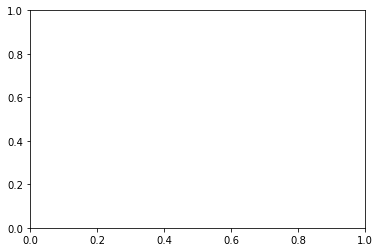

In [14]:
def show_linescan(p_opt, target, ax=plt.gca(), y=225, ss_x = slice(225,325)):
    n_pat = len(p_opt)
    Iout_instantaneous = phi_to_I_ff(p_opt, target) / n_pat
    line_intensity = Iout_instantaneous[:,y,ss_x]
    tg_line = target[y, ss_x]
    xaxis = ss_x.start + np.arange(tg_line.shape[-1])
    ax.plot(xaxis,tg_line, color='C1', lw=3, ls='-.')
    ax.plot(xaxis,line_intensity.sum(0), color='C0', lw=3)
    ax.set_prop_cycle(None)
    ax.plot([])
    ax.plot([])
    ax.set_ylim(0,1.6)
    if n_pat > 5:
        line_intensity = line_intensity*3
    ax.plot(xaxis,line_intensity.swapaxes(0,1), alpha=0.6)

def show_nccr_patterns(p_opt, target, ax=plt.gca()):
    n_pat = len(p_opt)
    Iout_instantaneous = phi_to_I_ff(p_opt, target)
    li = Iout_instantaneous.reshape(n_pat, -1) - target.reshape(1, -1) / n_pat
    li = li - li.mean(1, keepdims=True)
    li = li / np.std(li, axis=1, keepdims=True)
    xcorr=li@li.T/li.shape[-1]
    print(xcorr.min(), xcorr.max())
    im =ax.imshow(xcorr, clim=[-1,1], cmap='seismic')
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal' )
    cbar.solids.set_edgecolor("face")


In [15]:
# If running on google colab, save the figures directly to the drive. If not, don't.

from pathlib import Path
drive_path = Path('/content/drive/Shareddrives/TAP/TAP figures/Fig 1')
if not drive_path.exists():
    drive_path = Path('.')
drive_path# = Path('.')

PosixPath('.')


-0.8232959 1.0000001



-0.16654621 1.0000001



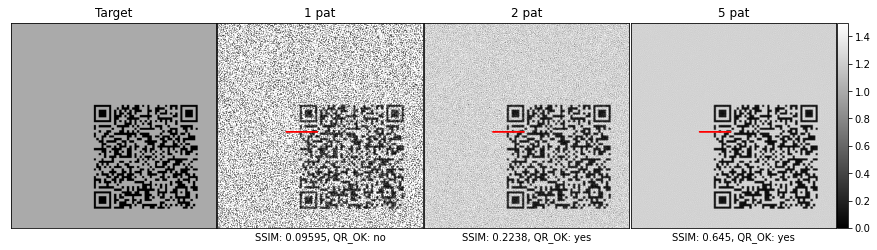

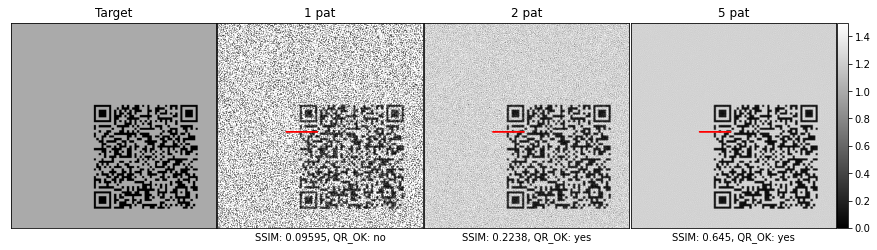

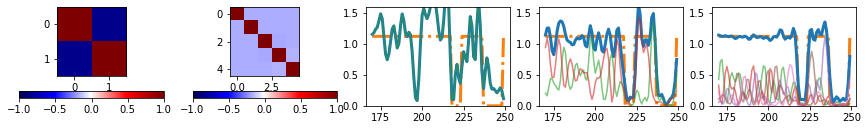

In [16]:
# show the influence of various numbers of patterns.
# The result of this cell is used in Fig. 1.
target = I_tg# - I_tg.min()
target = target / target.mean()

# number of patterns
npats = [1,2,5]

# make a plot with the right sizes
fig = plt.figure(figsize=(15,8))

ax = axes_grid1.AxesGrid(fig,111, (1,len(npats)+1), label_mode='llc', cbar_mode='single')
scaling = target.max()
im = ax.axes_all[0].imshow(target/scaling, cmap='gray', clim=[0,1.5])
ax[0].set_title('Target')
ax[0].xaxis.set_ticks([])
ax[0].yaxis.set_ticks([])
plt.colorbar(im, ax.cbar_axes[0])
ax = ax[1:]
# another plot for the line scans

fig_linescan, ax_linescan = plt.subplots(2, len(npats)+2, figsize=(15,4))
for ax_l in ax_linescan[0]:
    ax_l.set_visible(False)
ax_linescan = ax_linescan[1,:]


# show all of them
for i, npat in enumerate(tqdm(npats, desc='npat per frame')):
    # make the patterns
    p_opt, I_opt = optimize_time_averaged_projection(npat, n_its=500, I_tg=target)
    I_opt = jax.device_get(I_opt) / scaling / npat
    p_opt = jax.device_get(p_opt)
    ax[i].imshow(I_opt, cmap='gray', clim=[0,1.2], zorder=0)
    ax[i].set_title(f'{npat} pat')
    QR_OK = analyze_QR(I_opt, URL) and 'yes' or 'no'
    ssim_score = ssim(I_opt/I_opt.max(), target/target.max(), data_range=1)
    ax[i].set_xlabel(f'SSIM: {ssim_score:.4g}, QR_OK: {QR_OK}')
    ax[i].xaxis.set_ticks([])
    ax[i].yaxis.set_ticks([])

    # add a line section
    yy = 272
    ss_x = slice(170, 250)
    show_linescan(p_opt, target, ax_linescan[i+2], y=yy, ss_x=ss_x)
    if i > 0:
        show_nccr_patterns(p_opt, I_tg, ax_linescan[i-1])
    # add an indication in the original one
    ax[i].arrow(ss_x.start,yy, ss_x.stop-ss_x.start, 0, color='red')
    # add an indication in the axis
display(fig)

fig_linescan.savefig(drive_path/'Different_number_of_iterations_linescan.svg', dpi=300)
fig.savefig(drive_path/'Different_number_of_iterations.svg', dpi=300)



# Gerchberg-saxton-based intensity projection

In this section, we compare the performance of a Gerchberg-Saxton algorithm for single-pattern intensity projection to our inverse modelling approach, also using a single pattern. 


In [17]:
def fw(Ein, image_with_output_shape):
    """ Go from the SLM to the image projection plane, return fields """
    return FT(Ein, image_with_output_shape)

def bw(Eout):
    """ Go from the image projection plane to the SLM plane, return fields. """    
    out = jnp.fft.ifftshift(jnp.fft.ifft2(jnp.fft.fftshift(Eout))[...,:nprox, :nprox])
    return out * nprox**2


def test_fw_backward():
    """Test that bw(fw(x))==X"""
    Ein = np.random.rand(nprox, nprox)
    out = bw(fw(Ein, np.zeros((ndist, ndist)))).real
    from numpy.testing import assert_allclose
    try:
        assert_allclose(Ein, out, atol=1e-6)
    except AssertionError as e:
        plt.subplot(131)
        plt.imshow(Ein, clim=[0,1])
        plt.subplot(132)
        plt.imshow(out, clim=[0,1])
        plt.subplot(133)
        plt.imshow(Ein-out.real, clim=[-1e-6,1e-6])
        print('Error in bw(fw(x))')
        raise
    
test_fw_backward()
    

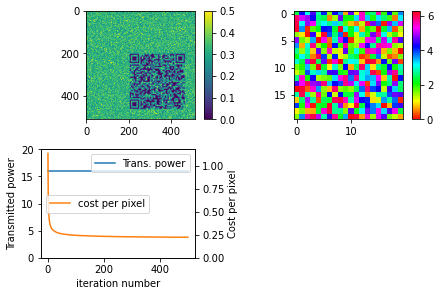

In [93]:
@jax.jit
def GS_algorithm(target_intensity=I_tg, iterations=np.arange(500), random_key=jax.random.PRNGKey(0)):
    """ Run a Gerchberg-saxton algorithm for single-pattern intensity projection, based on 
    
    https://www.osapublishing.org/oe/fulltext.cfm?uri=oe-19-20-18871&id=222508
    
    The equation numbers correspond to the equation numbers in the corresponding article.
    
    """
    
    
    # make an initial guess based on random phase patterns
    M = jnp.exp(1j*jax.random.normal(random_key, shape=(nprox,nprox),
                                     dtype=jnp.complex64)*10000)
    # the iterations are run in a scan as it increases the performance, see jax.lax.scan for details on scan.
    def scanfunc(carried, scanned):
        M = carried
        i = scanned

        # eq. (7)
        M = jnp.exp(1j*jnp.angle(M))
        # eq. (8)
        cq = fw(M, target_intensity)
        # eq. (9)
        cq_corrected = jnp.exp(1j*jnp.angle(cq))*jnp.sqrt(target_intensity)
        # eq. 10
        M = bw(cq_corrected)
        # calculate parameters of interest
        Iout = abs(cq**2)
        # parameters of interest: Intensity per iteration, Total transmitted power, and the loss per pixel normalized to the mean target intensity. 
        outputs = Iout/Iout.max(), Iout.sum(), loss_mse(Iout/Iout.mean(), target_intensity/target_intensity.mean())
        return M, outputs
    
    M, outputs = jax.lax.scan(scanfunc, M, iterations)    
    Iouts, Pouts, costs = outputs
    M = jnp.exp(1j*jnp.angle(M))
    return jnp.angle(M), Iouts, Pouts, costs

def visualize_GS_reconstruction(*args, **kwargs):
    """ Visualize a Gerchberg saxton algorithm, showing the resulting intensity, the value of the loss function, the transmitted power and a small piece of the
    resulting hologram. 
    """
    pattern, Iouts, Pouts, costs = GS_algorithm(*args, **kwargs)
    #Iout = abs(fw(pattern, np.zeros((ndist, ndist))))**2
    Iout = forward_ff(pattern[None], np.zeros((ndist, ndist)))
    Iout = Iout/Iout.max()
    fig, ax = plt.subplots(2,2, constrained_layout=True)
    
    im = ax[0][0].imshow(Iout, clim=[0,0.5])
    
    plt.colorbar(im, orientation='vertical', ax=ax[0,0])
    im = ax[0][1].imshow(pattern[...,20:40,20:40] % 2*np.pi, cmap='hsv', clim=[0,2*np.pi])
    plt.colorbar(im, orientation='vertical', ax=ax[0,1])
    ax[1,0].plot(Pouts, label='Trans. power', color='C0')
    ax[1,0].legend(loc=1)
    ax[1,0].set_ylim(0, 20)
    ax_y = ax[1,0].twinx()
    ax_y.plot(costs/ndist**2, label='cost per pixel', color='C1')
    ax_y.legend(loc=6)
    ax_y.set_ylim(0, None)
    ax_y.set_ylabel('Cost per pixel')
    ax[1,0].set_ylabel('Transmitted power')
    ax[1,0].set_xlabel('iteration number')
    
    ax[-1,-1].set_visible(False)
    
    
    
visualize_GS_reconstruction()
#plt.imshow(GS_algorithm()[1][-1], clim=[0,0.5])


In [74]:
def analyze_pattern(pattern, I_tg):
    """ Analyze a pattern in terms of transmitted power as well as the mean squared error. """
    # calculate the forward model
    while pattern.ndim < 3:
        pattern = pattern[None]
    I_out = forward_ff(pattern, I_tg)
    power = I_out.sum()
    cost = loss_mse(I_out/I_out.mean(), I_tg/I_tg.mean()) / ndist**2
    ssim_cost = ssim(I_out/I_out.mean(), I_tg/I_tg.mean(), data_range=I_tg.max()/I_tg.mean())
    print(f'Averaged transmitted power per pixel: {power/ndist**2:.3f}, MSE per pixel: {cost:.3f} SSIM: {ssim_cost:.3f}')
    return power, cost

The TAP and the GS algorithm have a similar performance. However, the SSIM of the GS algorithm is higher, indicating that it performs better.

In [92]:

p_TAP = optimize_time_averaged_projection(n_pat_per_frame=1,I_tg=I_tg)[0]
print('GS: ', end='\t')
analyze_pattern(GS_algorithm(iterations=jnp.arange(1500))[0], I_tg)
print('TAP:', end='\t')

analyze_pattern(p_TAP, I_tg)


GS: 	Averaged transmitted power per pixel: 1.000, MSE per pixel: 0.215 SSIM: 0.157
TAP:	Averaged transmitted power per pixel: 1.000, MSE per pixel: 0.169 SSIM: 0.141


/home/dbs660/anaconda3/envs/idp/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5771: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


(DeviceArray(262143.89, dtype=float32), DeviceArray(0.16913475, dtype=float32))

The main difference between these algorithms is that for the GS algorithm, an automatic scaling is applied. If we adjust the desired target intensity, a similar SSIM can be reached.

In [86]:
p_TAP = optimize_time_averaged_projection(n_pat_per_frame=1,I_tg=2.*I_tg)[0]
print('GS: ', end='\t')
analyze_pattern(GS_algorithm(iterations=jnp.arange(1500))[0], I_tg)
print('TAP:', end='\t')

analyze_pattern(p_TAP, I_tg)


GS: 	Averaged transmitted power per pixel: 1.000, MSE per pixel: 0.215 SSIM: 0.157
TAP:	Averaged transmitted power per pixel: 1.000, MSE per pixel: 0.184 SSIM: 0.158


(DeviceArray(262143.89, dtype=float32), DeviceArray(0.18353982, dtype=float32))

## Plot TAP and GS result
The final intensities look very similar. To see the original result, change the scaling of I_tg to 1.0 in the first line. The bars will appear less dark but much narrower.

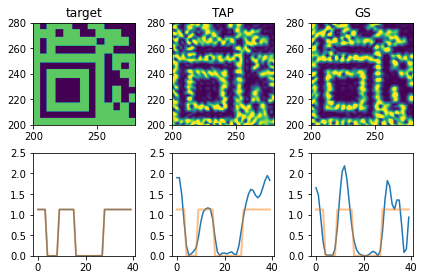

In [91]:

p_TAP = optimize_time_averaged_projection(n_pat_per_frame=1,I_tg=2.0*I_tg)[0]
I0 = I_tg
I2 = forward_ff(GS_algorithm()[0][None], I_tg)
I1 = forward_ff(p_TAP, I_tg) 
I0 = I0 / I0.mean()
I1 = I1 / I1.mean()
I2 = I2 / I2.mean()

for i, (I, title) in enumerate([(I0, 'target'), (I1, 'TAP'),
                                (I2, 'GS')]):
    ax = plt.subplot(2,3,i+1)
    ax.set_ylim(ax.set_xlim(200,280))
    ax.set_title(title)
    ax.imshow(I/I.mean(), clim=[0,1.5])
    
    ax = plt.subplot(2,3,i+4)
    ax.plot(I[240,240:280])
    ax.plot(I0[240,240:280], alpha=0.5, color='C1', lw=2)
    ax.set_ylim(0, 2.5)
plt.tight_layout()
